## Gender Classification using K Nearest Neighbors (KNN)

In [1]:
# import all the required libraries
import numpy as np
import pandas as pd
from Levenshtein import distance
import matplotlib.pyplot as plt

In [2]:
# Read the dataset
df = pd.read_csv("../assets/data/gender.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    1294 non-null   object
 1   Target  1294 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.3+ KB


In [4]:
df.head()

,Name,Target
0,Yash,1
1,Prit,1
2,Meet,1
3,Drashti,0
4,Saloni,0


In [6]:
# Converting all names to lowercase
df['Name'] = df['Name'].str.lower()
df.head()

,Name,Target
0,yash,1
1,prit,1
2,meet,1
3,drashti,0
4,saloni,0


In [7]:
female_count = df[df['Target'] == 0].shape[0]
male_count = df[df['Target'] == 1].shape[0]  

print(f"Number of girls: {female_count}")
print(f"Number of boys: {male_count}")

Number of girls: 679
Number of boys: 615


In [8]:
# Split data into train, validation and test sets
train_size = 0.8
test_size = 0.1
val_size = 0.1

num_rows = len(df)

train_rows = int(num_rows * train_size)
val_rows = int(num_rows * val_size)
test_rows = num_rows - train_rows - val_rows

# Create separate DataFrames for each set
train_df = df.iloc[:train_rows]
val_df = df.iloc[train_rows:train_rows + val_rows]
test_df = df.iloc[train_rows + val_rows:]

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))


Training set size: 1035
Validation set size: 129
Test set size: 130


In [9]:
"""
Distance Metric: The distance metric used here is the edit distance, also known as Levenshtein distance, which measures the number of character insertions, deletions, or substitutions required to change one string into another. A special adjustment is made when the edit distance is 1 and the names only differ by a vowel at the end (e.g., "Shrey" and "Shreya"). In such cases, based on domain knowledge, the labels of the training samples are swapped (using XOR on the label), which might represent handling specific domain nuances.
"""
def get_accuracy(train_df, test_df, k):
    correct = 0
    m = len(test_df)
    # print(f"Total number of samples: {m}")

    for i in range(len(test_df)):
        test_name = test_df.iloc[i][0]

        distances = []
        for j in range(len(train_df)):
            train_name = train_df.iloc[j][0]
            # Calculate minimum edit distance
            edit_dist = distance(test_name, train_name)

            # Special case if the edit distance is one and names differ by a vowel in end. For example, Shrey and Shreya.
            if ((edit_dist == 1) and ((len(train_name) > len(test_name) and train_name[:-1] == test_name) or (len(train_name) < len(test_name) and test_name[:-1] == train_name))):
                    # We swap the label in this case due to domain knowledge
                    distances.append((edit_dist, train_df.iloc[j][0], train_df.iloc[j][1]^1))
            else:
                distances.append((edit_dist, train_df.iloc[j][0], train_df.iloc[j][1]))

        # Sorting based on distance only
        distances.sort(key=lambda x: x[0]) 

        neighbors = distances[:k]
        votes = [neighbor[2] for neighbor in neighbors]
        prediction = max(set(votes), key=votes.count)
        if (prediction == test_df.iloc[i][1]):
            correct += 1

    # print(f"Number of correct predictions: {correct}")
    accuracy = correct / len(test_df)
    return accuracy

In [10]:
def get_weighted_accuracy(train_df, test_df, k):

    correct = 0
    m = len(test_df)

    for i in range(len(test_df)):
        test_name = test_df.iloc[i][0]

        distances = []
        for j in range(len(train_df)):
            train_name = train_df.iloc[j][0]
            # Calculate minimum edit distance (Levenshtein distance)
            edit_dist = distance(test_name, train_name)

            # Special case handling for names differing by a vowel at the end
            if ((edit_dist == 1) and ((len(train_name) > len(test_name) and train_name[:-1] == test_name) or (len(train_name) < len(test_name) and test_name[:-1] == train_name))):
                    # We swap the label in this case due to domain knowledge
                    distances.append((edit_dist, train_df.iloc[j][0], train_df.iloc[j][1]^1))
            else:
                distances.append((edit_dist, train_df.iloc[j][0], train_df.iloc[j][1]))

        # Sorting neighbors based on distance only
        distances.sort(key=lambda x: x[0])
        neighbors = distances[:k]
        
        # Weighted voting: weights are inverse of the distance
        votes = {}
        for neighbor in neighbors:
            weight = 1 / (neighbor[0] + 0.001)  # Assign weight inversely proportional to distance
            label = neighbor[2]  # Neighbor's label (0 or 1)
            if label in votes:
                votes[label] += weight
            else:
                votes[label] = weight

        prediction = max(votes, key=votes.get)
        if prediction == test_df.iloc[i][1]:
            correct += 1

    # Calculate accuracy
    accuracy = correct / len(test_df)
    return accuracy

Accuracy for k=3: 0.8294573643410853
Accuracy for k=5: 0.8372093023255814
Accuracy for k=7: 0.8527131782945736
Accuracy for k=9: 0.8527131782945736
Accuracy for k=11: 0.8604651162790697
Accuracy for k=13: 0.8372093023255814
Accuracy for k=15: 0.8604651162790697
Accuracy for k=17: 0.8682170542635659
Accuracy for k=19: 0.8604651162790697
Accuracy for k=21: 0.8837209302325582
Accuracy for k=23: 0.8837209302325582
Accuracy for k=25: 0.8682170542635659
Accuracy for k=27: 0.875968992248062
Accuracy for k=29: 0.875968992248062


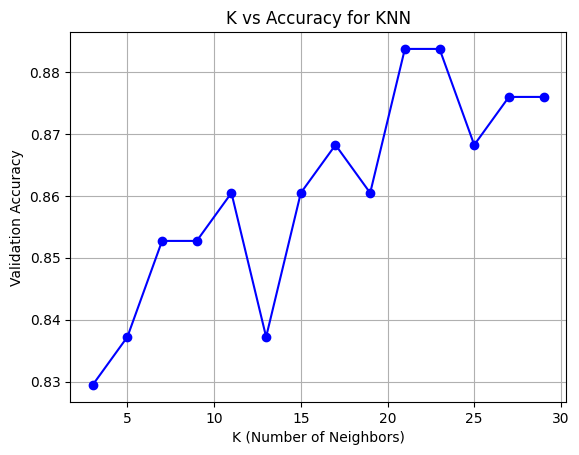

In [28]:
# Finding the optimal K for validation set
accuracies = []
for k in range(3, 30, 2):
    val_accuracy = get_accuracy(train_df, val_df, k)
    accuracies.append(val_accuracy)
    print(f'Accuracy for k={k}: {val_accuracy}')

# Create the plot
plt.plot(range(3, 30, 2), accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Validation Accuracy')
plt.title('K vs Accuracy for KNN')

plt.grid(True)
plt.show()

Accuracy for k=3: 0.8294573643410853
Accuracy for k=5: 0.8372093023255814
Accuracy for k=7: 0.8527131782945736
Accuracy for k=9: 0.8527131782945736
Accuracy for k=11: 0.8604651162790697
Accuracy for k=13: 0.8449612403100775
Accuracy for k=15: 0.8682170542635659
Accuracy for k=17: 0.875968992248062
Accuracy for k=19: 0.8682170542635659
Accuracy for k=21: 0.875968992248062
Accuracy for k=23: 0.8682170542635659
Accuracy for k=25: 0.8682170542635659
Accuracy for k=27: 0.8682170542635659
Accuracy for k=29: 0.8682170542635659


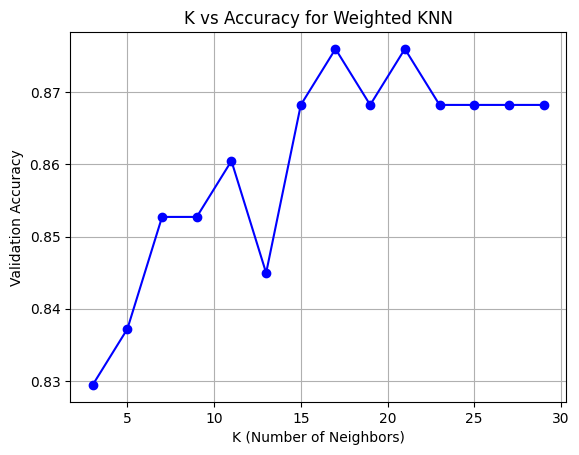

In [29]:
# Finding the optimal K for validation set
accuracies = []
for k in range(3, 30, 2):
    val_accuracy = get_weighted_accuracy(train_df, val_df, k)
    accuracies.append(val_accuracy)
    print(f'Accuracy for k={k}: {val_accuracy}')

# Create the plot
plt.plot(range(3, 30, 2), accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Validation Accuracy')
plt.title('K vs Accuracy for Weighted KNN')

plt.grid(True)
plt.show()

In [37]:
# Training on both train and validation dataset
K = 21
train_merged_df = pd.concat([train_df, val_df], ignore_index=True, sort=False)
accuracy = get_accuracy(train_merged_df, test_df, K)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.8384615384615385


In [31]:
# Training on both train and validation dataset
K = 17
train_merged_df = pd.concat([train_df, val_df], ignore_index=True, sort=False)
accuracy = get_weighted_accuracy(train_merged_df, test_df, K)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.8769230769230769


In [13]:
def predict(name):
    name = name.lower()
    K = 21

    distances = []
    for j in range(len(train_df)):
        train_name = train_df.iloc[j][0]
        # Calculate minimum edit distance
        edit_dist = distance(name, train_name)
        
        # Special case if the edit distance is one and names differ by a vowel in end. For example, Shrey and Shreya.
        if ((edit_dist == 1) and ((len(train_name) > len(name) and train_name[:-1] == name) or (len(train_name) < len(name) and name[:-1] == train_name))):
                    # We swap the label in this case due to domain knowledge
                distances.append((edit_dist, train_df.iloc[j][0], train_df.iloc[j][1]^1))
        else:
            distances.append((edit_dist, train_df.iloc[j][0], train_df.iloc[j][1]))

    # Sorting based on distance only
    distances.sort(key=lambda x: x[0]) 

    neighbors = distances[:K]
    votes = [neighbor[2] for neighbor in neighbors]
    prediction = max(set(votes), key=votes.count)
    
    if prediction == 1:
        print("I am sure " + name + " is a boy.")
    else:
        print("I am sure " + name + " is a girl.")
    
    print("Names with minimum edit distance are:", [neighbor[1] for neighbor in neighbors])

In [14]:
def weighted_predict(name):
    K = 17
    mame = name.lower()

    distances = []
    for j in range(len(train_df)):
        train_name = train_df.iloc[j][0]
        # Calculate minimum edit distance
        edit_dist = distance(name, train_name)
        
        # Special case if the edit distance is one and names differ by a vowel in end. For example, Shrey and Shreya.
        if ((edit_dist == 1) and ((len(train_name) > len(name) and train_name[:-1] == name) or (len(train_name) < len(name) and name[:-1] == train_name))):
                    # We swap the label in this case due to domain knowledge
                distances.append((edit_dist, train_df.iloc[j][0], train_df.iloc[j][1]^1))
        else:
            distances.append((edit_dist, train_df.iloc[j][0], train_df.iloc[j][1]))

    # Sorting based on distance only
    distances.sort(key=lambda x: x[0]) 

    neighbors = distances[:K]
    # Weighted voting: weights are inverse of the distance
    votes = {}
    for neighbor in neighbors:
        weight = 1 / (neighbor[0] + 0.001)  # Assign weight inversely proportional to distance
        label = neighbor[2]  # Neighbor's label (0 or 1)
        if label in votes:
            votes[label] += weight
        else:
            votes[label] = weight
        
    prediction = max(set(votes), key=votes.get)
    if prediction == 1:
        print("I am sure " + name + " is a boy.")
    else:
        print("I am sure " + name + " is a girl.")
    
    print("Names with minimum edit distance are:", [neighbor[1] for neighbor in neighbors])

In [15]:
# Testing with our own example
predict("Chandan")
predict("Raavan")
predict("Chandanbala")
predict("Mandodari")

I am sure chandan is a boy.
Names with minimum edit distance are: ['chandani', 'chintan', 'vandan', 'charan', 'chandni', 'shaan', 'champa', 'hanuman', 'shadab', 'chahat', 'manan', 'chaya', 'kundan', 'ranjan', 'chanchal', 'hinal', 'hardik', 'naman', 'bhavya', 'nayan', 'manthan']
I am sure raavan is a boy.
Names with minimum edit distance are: ['rajan', 'pavan', 'raavi', 'raman', 'rajan', 'savan', 'ranjan', 'naman', 'ravina', 'raghav', 'nayan', 'shaan', 'rohan', 'rehan', 'salman', 'roshan', 'pravin', 'ravi', 'tarjan', 'nayan', 'farhan']
I am sure chandanbala is a girl.
Names with minimum edit distance are: ['chandani', 'chitranjali', 'chandni', 'chanchal', 'ananya', 'sanjana', 'kadambari', 'shadab', 'dhanvarsha', 'vandna', 'chintan', 'vandan', 'charan', 'bhavana', 'shabana', 'vandna', 'hinal', 'anjali', 'shaan', 'shaila', 'hanshika']
I am sure mandodari is a girl.
Names with minimum edit distance are: ['manhar', 'manoj', 'manthan', 'anjali', 'manisha', 'chandani', 'mansi', 'mazida', 'kad

In [16]:
# Testing with our own example
weighted_predict("Chandan")
weighted_predict("Raavan")
weighted_predict("Chandanbala")
weighted_predict("Mandodari")

I am sure Chandan is a boy.
Names with minimum edit distance are: ['chandani', 'vandan', 'shaan', 'hanuman', 'shadab', 'manan', 'chintan', 'charan', 'kundan', 'ranjan', 'chandni', 'hinal', 'hardik', 'naman', 'bhavya', 'nayan', 'manthan']
I am sure Raavan is a boy.
Names with minimum edit distance are: ['pavan', 'savan', 'naman', 'nayan', 'shaan', 'salman', 'pravin', 'rajan', 'raavi', 'tarjan', 'nayan', 'farhan', 'manan', 'raman', 'dhaval', 'bhavin', 'karan']
I am sure Chandanbala is a girl.
Names with minimum edit distance are: ['chandani', 'ananya', 'sanjana', 'kadambari', 'shadab', 'dhanvarsha', 'vandna', 'chitranjali', 'vandan', 'bhavana', 'chandni', 'shabana', 'chanchal', 'vandna', 'hinal', 'anjali', 'shaan']
I am sure Mandodari is a girl.
Names with minimum edit distance are: ['anjali', 'chandani', 'kadambari', 'anushri', 'sandhya', 'vandna', 'anandi', 'sanskar', 'banasri', 'vandan', 'nandini', 'manhar', 'vandna', 'saloni', 'janvi', 'akshar', 'manoj']
